# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.45KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

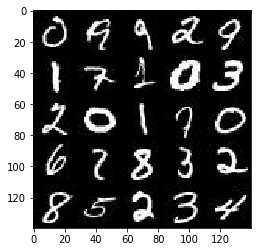

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

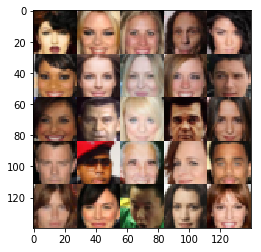

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_images')
    
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    
    learn_rate = tf.placeholder(tf.float32, None, name='learn_rate')

        
    return real_input_images, z_input, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        x1 = tf.maximum(x1*alpha, x1)
        
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2*alpha, x2)
        
        x3 = tf.layers.conv2d(x2, 512, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3*alpha, x3)
        
        flat = tf.reshape(x3, (-1,7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        full = tf.layers.dense(z, 7*7*256)
        
        x1 = tf.reshape(full, (-1,7,7,256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1* alpha, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2 * alpha, x2)
        
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3 * alpha, x3)
        
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #Build Model
    
    #Inputs
    real_input_images, z_input, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    #Calculate Loss
    d_loss, g_loss = model_loss(real_input_images, z_input, data_shape[3])
    #Optimize
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    samples, losses = [], []
    step = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1     
                
                batch_images = batch_images * 2
                # Create Z
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))                

                # Optimize
                _ = sess.run(d_train_opt, feed_dict={real_input_images: batch_images, z_input: batch_z, learn_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, real_input_images: batch_images, learn_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, real_input_images: batch_images, learn_rate:learning_rate})

                if step % 25 == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input_images: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
        
                if step % 100 == 0:
                    show_generator_output(sess, 15, z_input, data_shape[3], data_image_mode)
                
    
    return losses, samples
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 5.8184... Generator Loss: 1.6667
Epoch 1/2... Discriminator Loss: 4.1763... Generator Loss: 0.0187
Epoch 1/2... Discriminator Loss: 2.8180... Generator Loss: 0.3388
Epoch 1/2... Discriminator Loss: 3.0849... Generator Loss: 0.0641


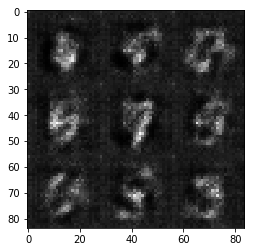

Epoch 1/2... Discriminator Loss: 2.0857... Generator Loss: 0.4476
Epoch 1/2... Discriminator Loss: 2.5283... Generator Loss: 0.1012
Epoch 1/2... Discriminator Loss: 2.6497... Generator Loss: 0.1009
Epoch 1/2... Discriminator Loss: 1.4065... Generator Loss: 0.3869


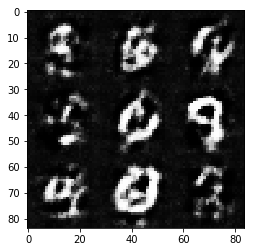

Epoch 1/2... Discriminator Loss: 1.1244... Generator Loss: 1.9622
Epoch 1/2... Discriminator Loss: 1.3105... Generator Loss: 1.5549
Epoch 1/2... Discriminator Loss: 1.7665... Generator Loss: 0.3071
Epoch 1/2... Discriminator Loss: 2.5262... Generator Loss: 0.1102


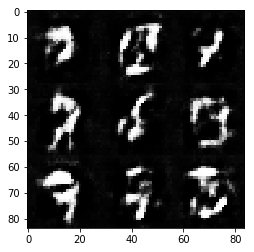

Epoch 1/2... Discriminator Loss: 1.3469... Generator Loss: 0.7807
Epoch 1/2... Discriminator Loss: 1.7284... Generator Loss: 0.2643
Epoch 1/2... Discriminator Loss: 1.4440... Generator Loss: 1.1390
Epoch 1/2... Discriminator Loss: 1.8805... Generator Loss: 0.2222


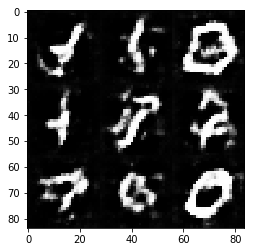

Epoch 1/2... Discriminator Loss: 1.2906... Generator Loss: 0.5822
Epoch 1/2... Discriminator Loss: 1.6054... Generator Loss: 1.4773
Epoch 1/2... Discriminator Loss: 1.6356... Generator Loss: 0.2920
Epoch 1/2... Discriminator Loss: 1.9996... Generator Loss: 0.2274


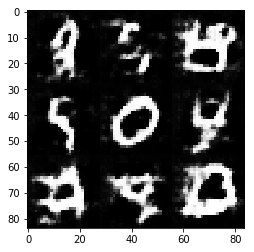

Epoch 1/2... Discriminator Loss: 1.1702... Generator Loss: 0.8591
Epoch 1/2... Discriminator Loss: 1.6769... Generator Loss: 0.2695
Epoch 1/2... Discriminator Loss: 2.5379... Generator Loss: 0.1181
Epoch 1/2... Discriminator Loss: 2.7169... Generator Loss: 0.0873


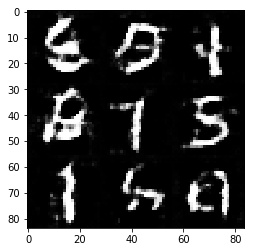

Epoch 1/2... Discriminator Loss: 2.1619... Generator Loss: 0.1492
Epoch 1/2... Discriminator Loss: 1.5281... Generator Loss: 0.3626
Epoch 1/2... Discriminator Loss: 2.2191... Generator Loss: 0.1908
Epoch 1/2... Discriminator Loss: 1.8210... Generator Loss: 0.2535


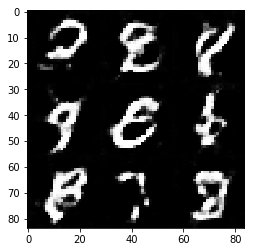

Epoch 1/2... Discriminator Loss: 2.3132... Generator Loss: 0.1544
Epoch 1/2... Discriminator Loss: 1.2655... Generator Loss: 0.5593
Epoch 1/2... Discriminator Loss: 1.2318... Generator Loss: 0.5252
Epoch 1/2... Discriminator Loss: 1.5922... Generator Loss: 1.3152


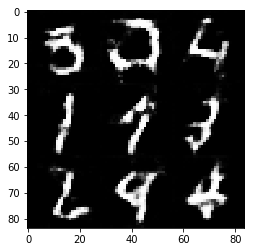

Epoch 1/2... Discriminator Loss: 2.4292... Generator Loss: 0.1287
Epoch 1/2... Discriminator Loss: 1.6363... Generator Loss: 0.3131
Epoch 1/2... Discriminator Loss: 2.4542... Generator Loss: 0.1521
Epoch 1/2... Discriminator Loss: 2.2978... Generator Loss: 0.1463


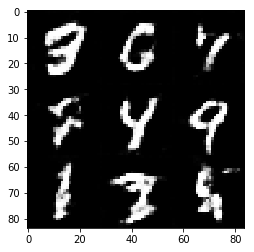

Epoch 1/2... Discriminator Loss: 1.6027... Generator Loss: 0.3637
Epoch 1/2... Discriminator Loss: 1.6100... Generator Loss: 0.3077
Epoch 1/2... Discriminator Loss: 3.1999... Generator Loss: 0.0552
Epoch 1/2... Discriminator Loss: 2.3365... Generator Loss: 0.1405


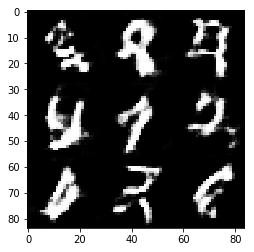

Epoch 1/2... Discriminator Loss: 1.6227... Generator Loss: 0.3373
Epoch 1/2... Discriminator Loss: 1.9053... Generator Loss: 0.2869
Epoch 1/2... Discriminator Loss: 1.3673... Generator Loss: 0.4380
Epoch 1/2... Discriminator Loss: 1.4726... Generator Loss: 0.4632


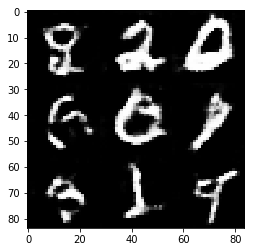

Epoch 1/2... Discriminator Loss: 2.2852... Generator Loss: 0.1550
Epoch 1/2... Discriminator Loss: 1.4935... Generator Loss: 0.3583
Epoch 1/2... Discriminator Loss: 1.5222... Generator Loss: 1.2049
Epoch 1/2... Discriminator Loss: 1.9084... Generator Loss: 0.2461


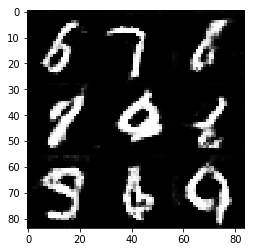

Epoch 1/2... Discriminator Loss: 1.9078... Generator Loss: 0.2346
Epoch 1/2... Discriminator Loss: 2.3678... Generator Loss: 0.1426
Epoch 1/2... Discriminator Loss: 1.8124... Generator Loss: 0.2851
Epoch 1/2... Discriminator Loss: 2.0758... Generator Loss: 0.2116


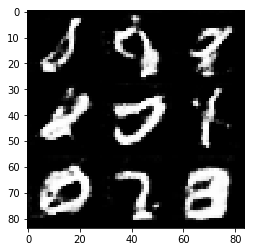

Epoch 1/2... Discriminator Loss: 1.1468... Generator Loss: 0.8308
Epoch 1/2... Discriminator Loss: 2.3154... Generator Loss: 0.1474
Epoch 1/2... Discriminator Loss: 1.8281... Generator Loss: 0.2751
Epoch 1/2... Discriminator Loss: 1.2392... Generator Loss: 0.5865


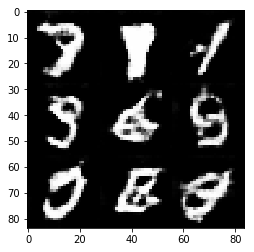

Epoch 1/2... Discriminator Loss: 2.2622... Generator Loss: 0.1597
Epoch 1/2... Discriminator Loss: 1.2329... Generator Loss: 0.5305
Epoch 1/2... Discriminator Loss: 1.4846... Generator Loss: 1.7485
Epoch 1/2... Discriminator Loss: 2.6962... Generator Loss: 0.1016


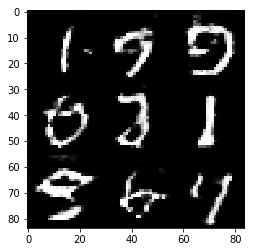

Epoch 1/2... Discriminator Loss: 1.0733... Generator Loss: 2.0863
Epoch 1/2... Discriminator Loss: 2.6182... Generator Loss: 0.0974
Epoch 1/2... Discriminator Loss: 1.7739... Generator Loss: 0.2840
Epoch 1/2... Discriminator Loss: 1.9569... Generator Loss: 0.1979


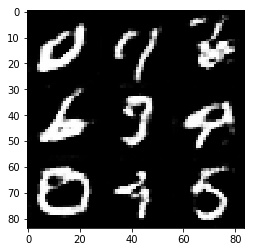

Epoch 1/2... Discriminator Loss: 2.0096... Generator Loss: 0.2097
Epoch 1/2... Discriminator Loss: 0.9276... Generator Loss: 1.0293
Epoch 1/2... Discriminator Loss: 1.2554... Generator Loss: 1.0131
Epoch 1/2... Discriminator Loss: 1.9733... Generator Loss: 0.2322


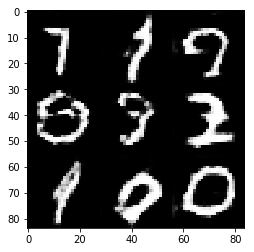

Epoch 1/2... Discriminator Loss: 2.8625... Generator Loss: 0.0853
Epoch 1/2... Discriminator Loss: 1.8763... Generator Loss: 0.2620
Epoch 1/2... Discriminator Loss: 1.2043... Generator Loss: 0.7862
Epoch 1/2... Discriminator Loss: 2.0612... Generator Loss: 0.1946


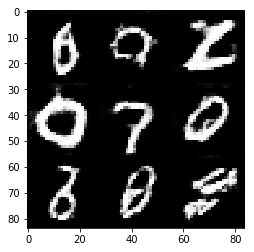

Epoch 1/2... Discriminator Loss: 2.7571... Generator Loss: 0.1057
Epoch 1/2... Discriminator Loss: 2.0477... Generator Loss: 0.2216
Epoch 1/2... Discriminator Loss: 0.9210... Generator Loss: 0.7798
Epoch 2/2... Discriminator Loss: 2.6602... Generator Loss: 0.1176


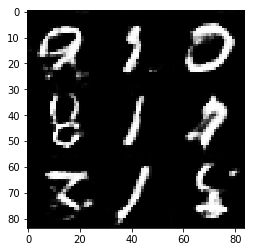

Epoch 2/2... Discriminator Loss: 0.8438... Generator Loss: 1.0971
Epoch 2/2... Discriminator Loss: 1.8561... Generator Loss: 0.2634
Epoch 2/2... Discriminator Loss: 2.4780... Generator Loss: 0.1275
Epoch 2/2... Discriminator Loss: 1.9969... Generator Loss: 0.2640


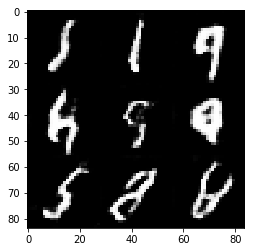

Epoch 2/2... Discriminator Loss: 2.8546... Generator Loss: 0.0893
Epoch 2/2... Discriminator Loss: 2.7541... Generator Loss: 0.1193
Epoch 2/2... Discriminator Loss: 1.1482... Generator Loss: 1.3519
Epoch 2/2... Discriminator Loss: 1.4471... Generator Loss: 0.4487


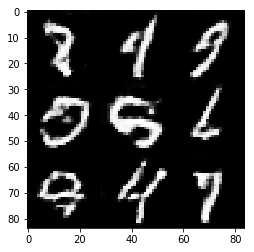

Epoch 2/2... Discriminator Loss: 1.0344... Generator Loss: 1.0083
Epoch 2/2... Discriminator Loss: 1.1412... Generator Loss: 0.8364
Epoch 2/2... Discriminator Loss: 1.8145... Generator Loss: 0.2728
Epoch 2/2... Discriminator Loss: 3.2828... Generator Loss: 0.0711


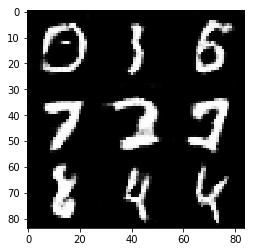

Epoch 2/2... Discriminator Loss: 1.6904... Generator Loss: 2.9234
Epoch 2/2... Discriminator Loss: 1.6779... Generator Loss: 0.3166
Epoch 2/2... Discriminator Loss: 1.7719... Generator Loss: 0.3224
Epoch 2/2... Discriminator Loss: 1.5105... Generator Loss: 0.4029


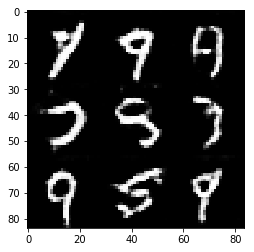

Epoch 2/2... Discriminator Loss: 1.5920... Generator Loss: 0.3428
Epoch 2/2... Discriminator Loss: 1.4620... Generator Loss: 0.4915
Epoch 2/2... Discriminator Loss: 1.1453... Generator Loss: 1.7385
Epoch 2/2... Discriminator Loss: 1.3276... Generator Loss: 0.5182


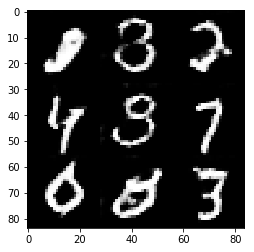

Epoch 2/2... Discriminator Loss: 2.3873... Generator Loss: 0.1946
Epoch 2/2... Discriminator Loss: 4.6734... Generator Loss: 5.0847
Epoch 2/2... Discriminator Loss: 1.2891... Generator Loss: 0.4827
Epoch 2/2... Discriminator Loss: 1.5173... Generator Loss: 0.3481


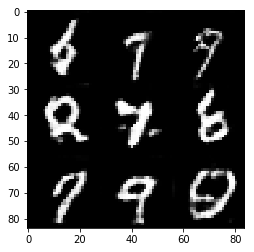

Epoch 2/2... Discriminator Loss: 1.5202... Generator Loss: 0.3978
Epoch 2/2... Discriminator Loss: 1.9526... Generator Loss: 0.2437
Epoch 2/2... Discriminator Loss: 2.5721... Generator Loss: 0.1419
Epoch 2/2... Discriminator Loss: 2.2986... Generator Loss: 0.1567


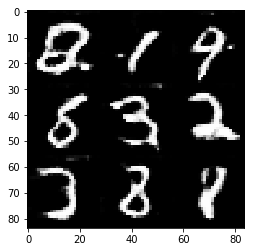

Epoch 2/2... Discriminator Loss: 1.7917... Generator Loss: 0.3082
Epoch 2/2... Discriminator Loss: 1.2435... Generator Loss: 0.4936
Epoch 2/2... Discriminator Loss: 1.8508... Generator Loss: 0.3036
Epoch 2/2... Discriminator Loss: 2.2934... Generator Loss: 0.1545


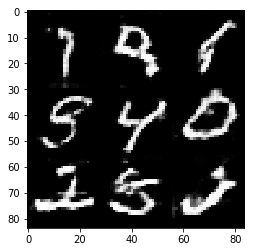

Epoch 2/2... Discriminator Loss: 2.3446... Generator Loss: 0.1535
Epoch 2/2... Discriminator Loss: 1.9243... Generator Loss: 0.2754
Epoch 2/2... Discriminator Loss: 0.6110... Generator Loss: 1.2926
Epoch 2/2... Discriminator Loss: 0.9678... Generator Loss: 0.7221


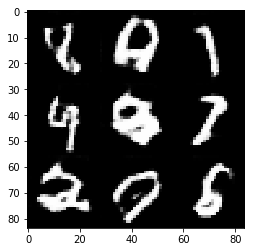

Epoch 2/2... Discriminator Loss: 2.8861... Generator Loss: 0.0928
Epoch 2/2... Discriminator Loss: 1.2136... Generator Loss: 0.4910
Epoch 2/2... Discriminator Loss: 1.2012... Generator Loss: 3.5463
Epoch 2/2... Discriminator Loss: 2.4307... Generator Loss: 0.1702


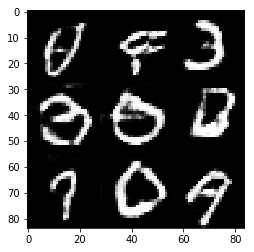

Epoch 2/2... Discriminator Loss: 1.6113... Generator Loss: 0.4009
Epoch 2/2... Discriminator Loss: 1.6285... Generator Loss: 0.3397
Epoch 2/2... Discriminator Loss: 0.6187... Generator Loss: 1.4604
Epoch 2/2... Discriminator Loss: 1.9018... Generator Loss: 0.2392


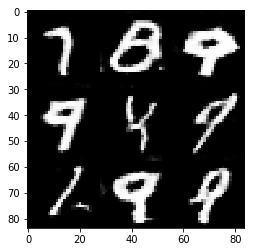

Epoch 2/2... Discriminator Loss: 2.1045... Generator Loss: 0.1825
Epoch 2/2... Discriminator Loss: 1.3514... Generator Loss: 0.5931
Epoch 2/2... Discriminator Loss: 1.8518... Generator Loss: 0.3069
Epoch 2/2... Discriminator Loss: 0.9865... Generator Loss: 1.1053


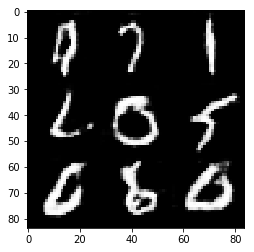

Epoch 2/2... Discriminator Loss: 2.5450... Generator Loss: 0.1799
Epoch 2/2... Discriminator Loss: 2.7109... Generator Loss: 0.1439
Epoch 2/2... Discriminator Loss: 0.9231... Generator Loss: 0.8817
Epoch 2/2... Discriminator Loss: 1.8125... Generator Loss: 0.2477


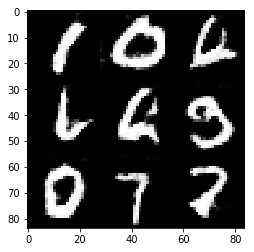

Epoch 2/2... Discriminator Loss: 2.2050... Generator Loss: 0.2366
Epoch 2/2... Discriminator Loss: 1.1872... Generator Loss: 1.7390
Epoch 2/2... Discriminator Loss: 1.6983... Generator Loss: 0.5307
Epoch 2/2... Discriminator Loss: 1.0474... Generator Loss: 0.6119


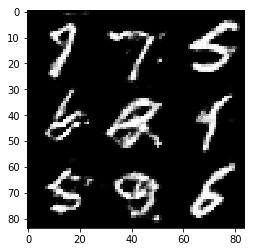

Epoch 2/2... Discriminator Loss: 1.8258... Generator Loss: 0.3081
Epoch 2/2... Discriminator Loss: 3.9544... Generator Loss: 0.1042
Epoch 2/2... Discriminator Loss: 1.1544... Generator Loss: 2.1850
Epoch 2/2... Discriminator Loss: 0.7692... Generator Loss: 1.2988


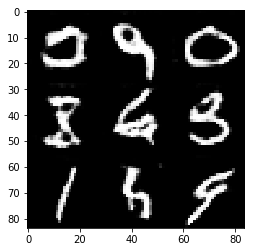

Epoch 2/2... Discriminator Loss: 2.3564... Generator Loss: 0.1498
Epoch 2/2... Discriminator Loss: 2.7489... Generator Loss: 0.1473
Epoch 2/2... Discriminator Loss: 2.4181... Generator Loss: 0.1294
Epoch 2/2... Discriminator Loss: 1.4499... Generator Loss: 0.4982


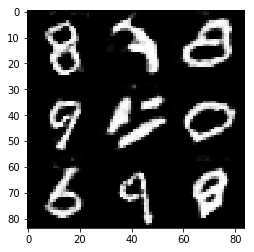

Epoch 2/2... Discriminator Loss: 1.3071... Generator Loss: 0.5109
Epoch 2/2... Discriminator Loss: 0.7788... Generator Loss: 1.2660
Epoch 2/2... Discriminator Loss: 1.5140... Generator Loss: 0.4227
Epoch 2/2... Discriminator Loss: 1.0345... Generator Loss: 0.7837


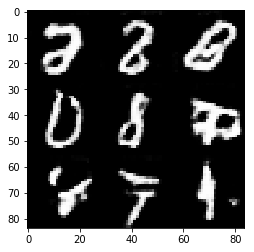

Epoch 2/2... Discriminator Loss: 1.8774... Generator Loss: 0.2859
Epoch 2/2... Discriminator Loss: 0.9343... Generator Loss: 0.8246
Epoch 2/2... Discriminator Loss: 3.3275... Generator Loss: 0.0678
Epoch 2/2... Discriminator Loss: 1.3635... Generator Loss: 0.4483


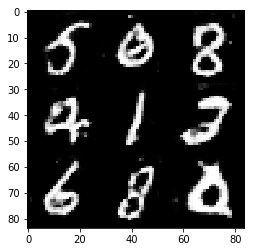

Epoch 2/2... Discriminator Loss: 2.2045... Generator Loss: 0.2173
Epoch 2/2... Discriminator Loss: 2.2881... Generator Loss: 0.1686


In [22]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = .3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 15.1778... Generator Loss: 0.0000
Epoch 1/1... Discriminator Loss: 6.1612... Generator Loss: 2.4282
Epoch 1/1... Discriminator Loss: 2.8836... Generator Loss: 0.2443
Epoch 1/1... Discriminator Loss: 5.7484... Generator Loss: 0.0376


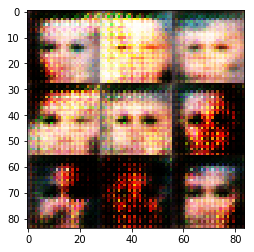

Epoch 1/1... Discriminator Loss: 3.4612... Generator Loss: 0.1160
Epoch 1/1... Discriminator Loss: 2.5339... Generator Loss: 1.6993
Epoch 1/1... Discriminator Loss: 3.3952... Generator Loss: 1.3822
Epoch 1/1... Discriminator Loss: 1.9070... Generator Loss: 1.7713


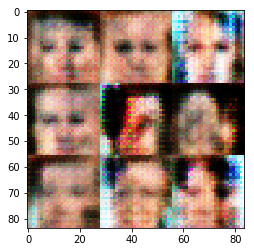

Epoch 1/1... Discriminator Loss: 1.9183... Generator Loss: 0.2910
Epoch 1/1... Discriminator Loss: 2.2398... Generator Loss: 0.2068
Epoch 1/1... Discriminator Loss: 2.1059... Generator Loss: 0.2322
Epoch 1/1... Discriminator Loss: 2.8975... Generator Loss: 0.1004


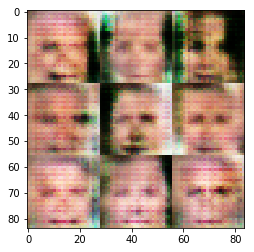

Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 1.2207
Epoch 1/1... Discriminator Loss: 2.1777... Generator Loss: 0.2071
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 2.3837... Generator Loss: 0.1513


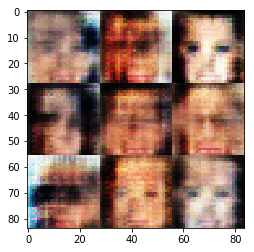

Epoch 1/1... Discriminator Loss: 1.8858... Generator Loss: 0.5413
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 2.4739... Generator Loss: 1.5031
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.9041


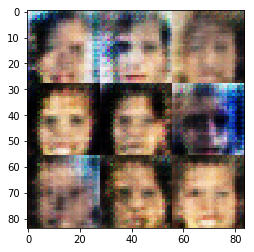

Epoch 1/1... Discriminator Loss: 1.8226... Generator Loss: 0.4694
Epoch 1/1... Discriminator Loss: 1.7087... Generator Loss: 0.4519
Epoch 1/1... Discriminator Loss: 1.6966... Generator Loss: 0.4139
Epoch 1/1... Discriminator Loss: 1.7093... Generator Loss: 0.5598


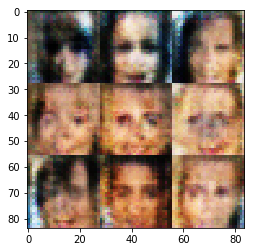

Epoch 1/1... Discriminator Loss: 1.7741... Generator Loss: 0.3655
Epoch 1/1... Discriminator Loss: 1.7882... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.8453... Generator Loss: 0.4142
Epoch 1/1... Discriminator Loss: 1.5511... Generator Loss: 0.5001


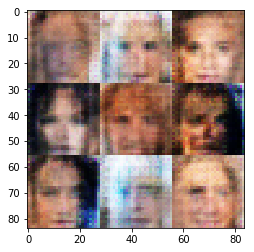

Epoch 1/1... Discriminator Loss: 1.7411... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.6286... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.4980
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6280


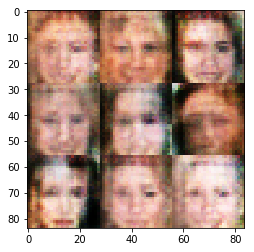

Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.5531
Epoch 1/1... Discriminator Loss: 1.6290... Generator Loss: 0.3825
Epoch 1/1... Discriminator Loss: 1.5730... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 2.0812... Generator Loss: 0.3174


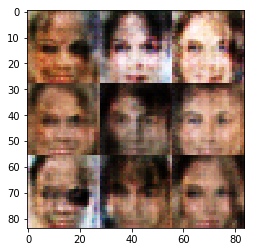

Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.4671
Epoch 1/1... Discriminator Loss: 1.6588... Generator Loss: 0.3920
Epoch 1/1... Discriminator Loss: 1.6544... Generator Loss: 0.4742
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.5417


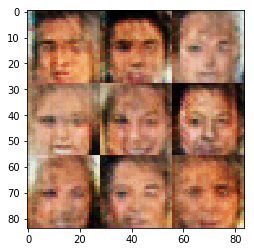

Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 1.5587... Generator Loss: 0.4409
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.5352... Generator Loss: 0.5527


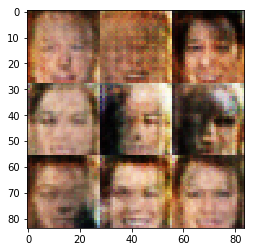

Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.5618
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 1.6519... Generator Loss: 0.4172


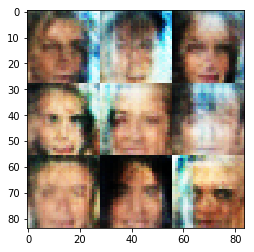

Epoch 1/1... Discriminator Loss: 1.6075... Generator Loss: 0.5257
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 2.2456... Generator Loss: 1.3602
Epoch 1/1... Discriminator Loss: 1.6290... Generator Loss: 0.6674


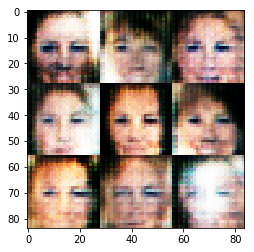

Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.7091... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.6463... Generator Loss: 0.6214


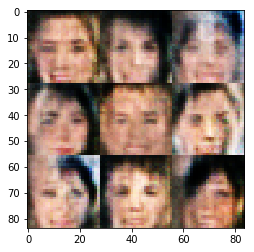

Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.6855... Generator Loss: 0.5748
Epoch 1/1... Discriminator Loss: 1.6091... Generator Loss: 0.5185


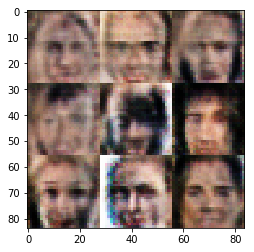

Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.5580... Generator Loss: 0.5625


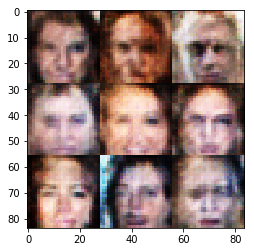

Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.5325... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.5942


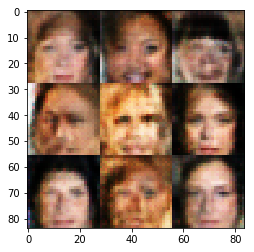

Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7188


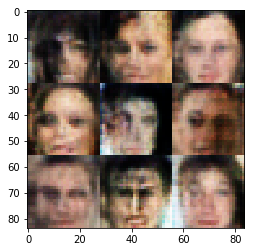

Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.5207... Generator Loss: 0.5109


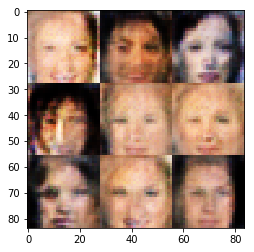

Epoch 1/1... Discriminator Loss: 1.6109... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.5272... Generator Loss: 0.5723


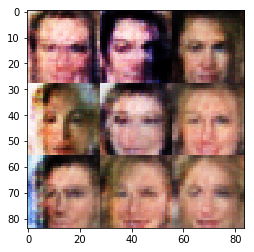

Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.7295


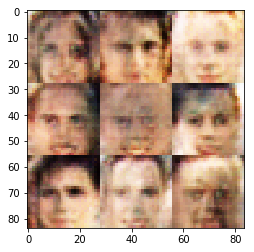

Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.6029... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.6848


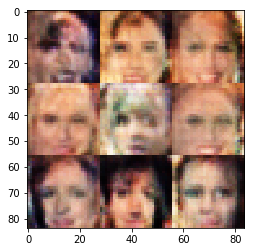

Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.5426... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.5744


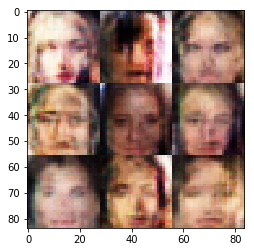

Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.7778


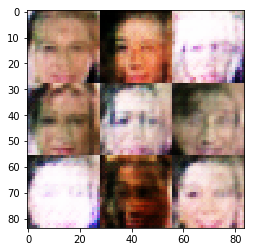

Epoch 1/1... Discriminator Loss: 1.5663... Generator Loss: 0.5642
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.6840


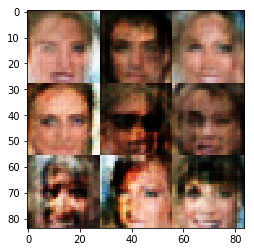

Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.5029... Generator Loss: 0.5100
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.6494


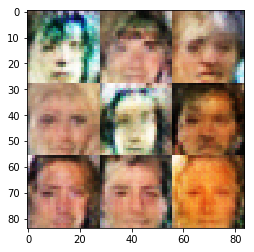

Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.5552
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.5620


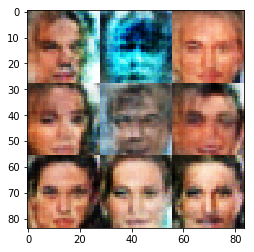

Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 0.4511


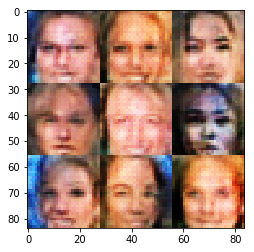

Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.5138
Epoch 1/1... Discriminator Loss: 1.5954... Generator Loss: 0.4899
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.6250


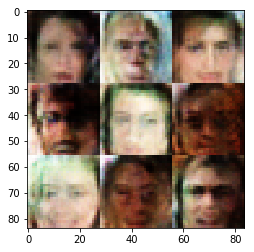

Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.6184


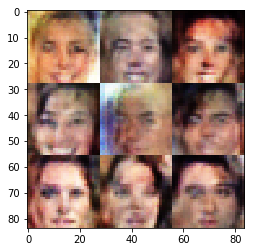

Epoch 1/1... Discriminator Loss: 1.6468... Generator Loss: 0.3930
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.5898
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.6607


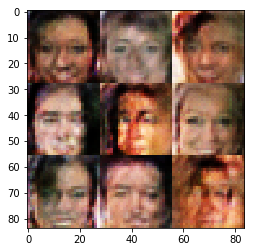

Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.5212... Generator Loss: 0.6168


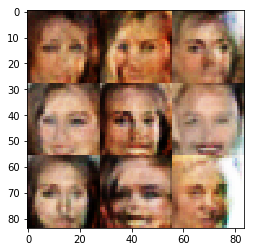

Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.5346
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.5771


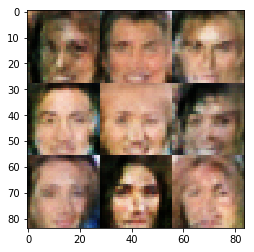

Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.5742
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.6647


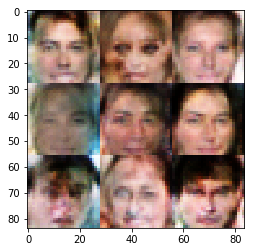

Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.5741... Generator Loss: 0.5164
Epoch 1/1... Discriminator Loss: 1.5921... Generator Loss: 0.5188
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.7586


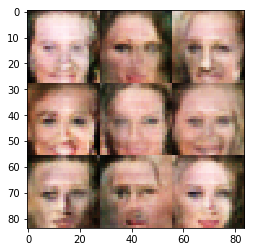

Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.6185


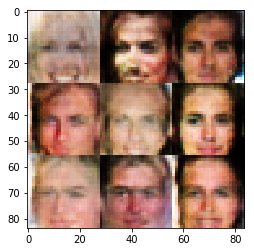

Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.5018


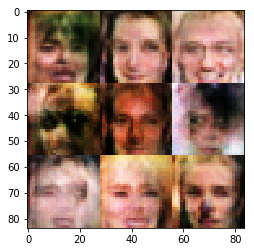

Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.5870
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.6191


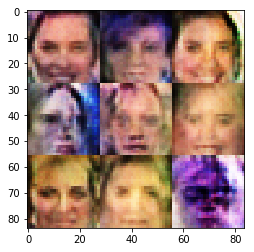

Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.6392


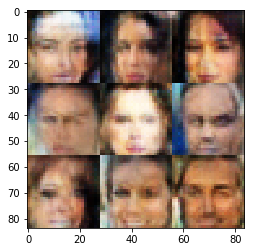

Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.5978
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.6709


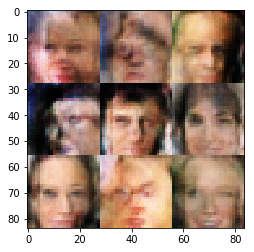

Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 1.5651... Generator Loss: 0.5409


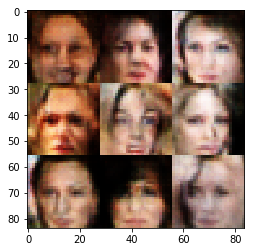

Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.5502... Generator Loss: 0.5243
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.5715
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6449


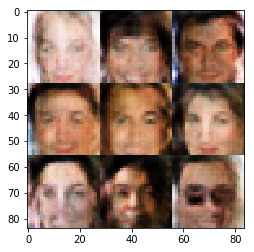

Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.5729
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.6929


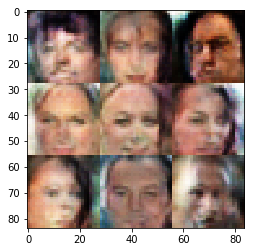

Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.5857


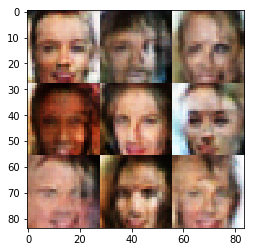

Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.5572


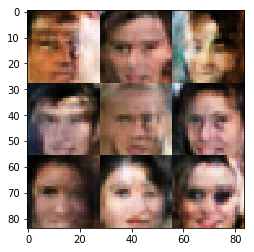

Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.5994


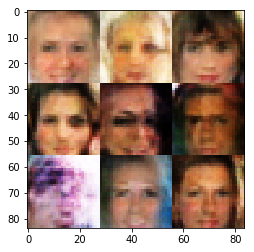

Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.6384


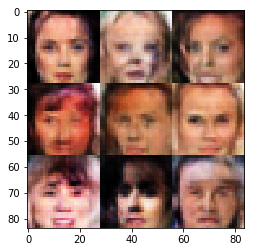

Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.5346
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.6293


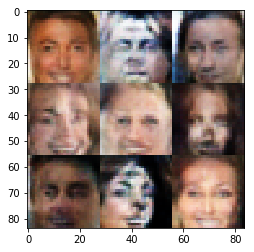

Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.5889


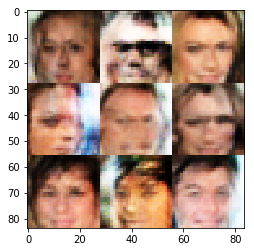

Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6430


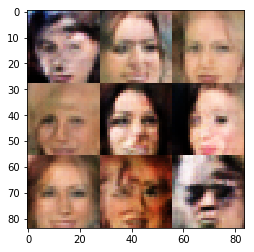

Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.6340


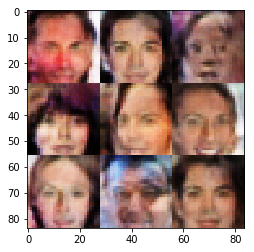

Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.5272... Generator Loss: 0.5860


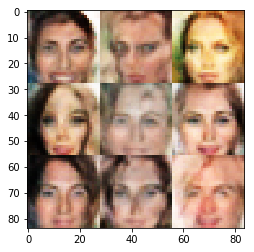

Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.5603
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.5568
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.6242


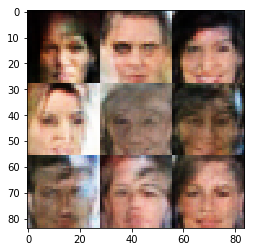

Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.6147


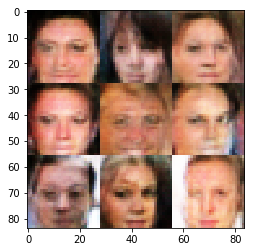

Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.6898


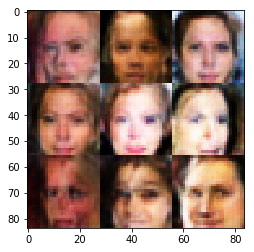

Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.6213


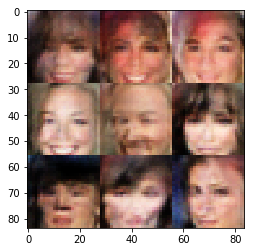

Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.5726


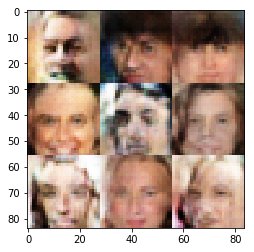

Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.5984


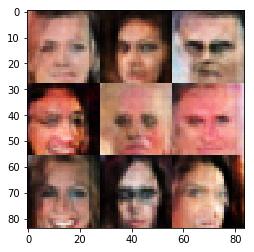

Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.5912
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6612


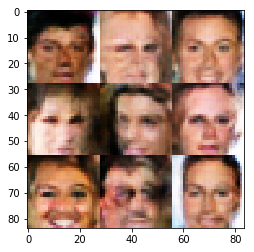

Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.5718


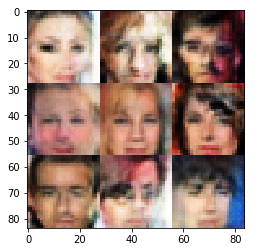

Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.6749


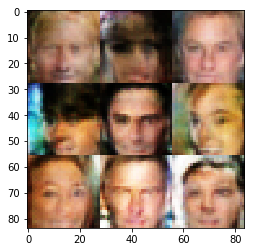

Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.5694
Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.5495


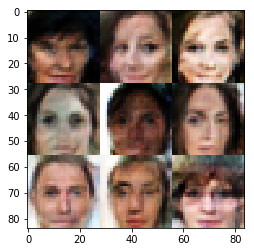

Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.5453... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.5838


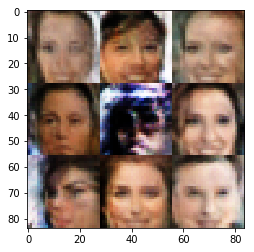

Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.6302


In [23]:
batch_size = 32
z_dim = 200
learning_rate = .002
beta1 = .3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.